# Model-X knockoffs

This tutorial is for generating model-X knockoffs, which handles cases where covariates outnumber sample size ($p > n$). The methodology is described in the following paper

> Candes E, Fan Y, Janson L, Lv J. *Panning for gold:‘model‐X’knockoffs for high dimensional controlled variable selection.* Journal of the Royal Statistical Society: Series B (Statistical Methodology). 2018 Jun;80(3):551-77.

In [2]:
# load packages needed for this tutorial
using Knockoffs
using Random
using GLMNet
using Distributions
using LinearAlgebra
using ToeplitzMatrices
using StatsKit
using Plots
gr(fmt=:png);

## Gaussian model-X knockoffs with known mean and covariance

To illustrate, lets simulate data $\mathbf{X}$ with covariance $\Sigma$ and mean $\mu$. Our model is
```math
\begin{aligned}
    X_{p \times 1} \sim N(\mathbf{0}_p, \Sigma)
\end{aligned}
```
where
```math
\begin{aligned}
\Sigma = 
\begin{pmatrix}
    1 & \rho & \rho^2 & ... & \rho^p\\
    \rho & 1 & & ... & \rho^{p-1}\\
    \vdots & & & 1 & \vdots \\
    \rho^p & \cdots & & & 1
\end{pmatrix}
\end{aligned}
```
Given $n$ iid samples from the above distribution, we will generate knockoffs according to 
```math
\begin{aligned}
(X, \tilde{X}) \sim N
\left(0, \ 
\begin{pmatrix}
    \Sigma & \Sigma - diag(s)\\
    \Sigma - diag(s) & \Sigma
\end{pmatrix}
\right)
\end{aligned}
```
where $s$ is solved so that $0 \le s_j \le \Sigma_{jj}$ for all $j$ and $2Σ - diag(s)$ is PSD. 

In [27]:
Random.seed!(2022)
n = 500 # sample size
p = 1000 # number of covariates
ρ = 0.4
Σ = Matrix(SymmetricToeplitz(ρ.^(0:(p-1)))) # true covariance matrix
μ = zeros(p) # true mean parameters
L = cholesky(Σ).L
X = randn(n, p) * L # var(X) = L var(N(0, 1)) L' = var(Σ)

500×1000 Matrix{Float64}:
 -0.255643    0.12145      1.90832   …  -0.425334  -0.0875185  -1.26044
  1.21857    -1.04975     -1.93608       0.986266   0.495375    0.526645
 -0.489054   -0.325137    -0.389752     -0.54062   -0.765207   -0.925541
  1.13077     0.715132     0.115053     -0.866809   0.835603    1.41018
 -2.06667    -0.799976     0.104784     -1.10473   -1.53618    -1.48403
 -0.692878   -1.04012     -0.711309  …   0.117786   0.419314    1.05
  0.605767   -0.220341    -0.62107       1.36572   -0.454627   -0.226038
 -0.156307    0.0225261   -0.117329      1.06143    1.35028     1.0699
  0.443743    2.41354      0.635028      0.744278   0.229644   -0.640157
  0.710929    0.0527427    1.35858       1.06147   -0.142669   -1.67164
  0.785485    1.72134     -1.02638   …  -0.222289  -0.903092   -0.237564
 -0.0330742   1.02192      0.367135     -0.412167   0.127533   -0.0828143
 -2.01006    -0.858529    -0.817414      1.52695    1.67114     2.15544
  ⋮                                

To generate model-X knockoffs,
+ The 4 argument function [`modelX_gaussian_knockoffs`](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.modelX_gaussian_knockoffs) will generate exact model-X knockoffs. 
+ First argument is the design matrix `X`. 
+ The second argument specifies the optimization method to generate knockoffs. We recommend `:mvr` or `:maxent` because they are [more efficient to compute and tend to be more powerful than the SDP construction](https://projecteuclid.org/journals/annals-of-statistics/volume-50/issue-1/Powerful-knockoffs-via-minimizing-reconstructability/10.1214/21-AOS2104.short). 
+ The 3rd and 4th argument supplies the true mean and covariance of features.

In [28]:
# for larger problems, consider including `verbose=true` argument to monitor convergence
@time equi = modelX_gaussian_knockoffs(X, :equi, μ, Σ)
@time mvr = modelX_gaussian_knockoffs(X, :mvr, μ, Σ)
@time me = modelX_gaussian_knockoffs(X, :maxent, μ, Σ);

  0.098400 seconds (46 allocations: 69.561 MiB)
  3.328117 seconds (59 allocations: 100.117 MiB)
  1.929832 seconds (57 allocations: 100.102 MiB)


The return type is a `GaussianKnockoff` struct, which contains the following fields

```julia
struct GaussianKnockoff{T<:AbstractFloat, M<:AbstractMatrix, S <: Symmetric} <: Knockoff
    X::M # n × p design matrix
    X̃::Matrix{T} # n × p knockoff of X
    s::Vector{T} # p × 1 vector. Diagonal(s) and 2Σ - Diagonal(s) are both psd
    Σ::S # p × p symmetric covariance matrix. 
    method::Symbol # method for solving s
end
```

Thus, to access these fields, one can do e.g.

In [29]:
s = mvr.s

1000-element Vector{Float64}:
 0.7055844308562433
 0.550600272751968
 0.5579639876207405
 0.5578996993527637
 0.557883689440236
 0.5578849315291078
 0.5578848927508967
 0.5578848919247213
 0.5578848920850612
 0.557884892075635
 0.557884892074806
 0.5578848920738697
 0.5578848920729174
 ⋮
 0.5578848730690327
 0.5578848733890451
 0.5578848767064315
 0.5578848743329564
 0.5578848745291356
 0.557884875752427
 0.5578849142012816
 0.5578836722536301
 0.5578996821189737
 0.557963970313357
 0.5506002575404055
 0.7055843980219556

In [30]:
# compare s values for different methods
[me.s mvr.s equi.s]

1000×3 Matrix{Float64}:
 0.760607  0.705584  0.857145
 0.599795  0.5506    0.857145
 0.611403  0.557964  0.857145
 0.610539  0.5579    0.857145
 0.610604  0.557884  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 ⋮                   
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610599  0.557885  0.857145
 0.610603  0.557884  0.857145
 0.610539  0.5579    0.857145
 0.611403  0.557964  0.857145
 0.599795  0.5506    0.857145
 0.760607  0.705584  0.857145

## Second order knockoffs

In practice, one usually do not have access to true mean `\mu` and covariance `\Sigma`. Thus, we provide routines to estimate them from data. In our software, the covariance is approximated by a shrinkage method (default = ledoit wolf) rather than using the sample covariance, see API for detail. 

The 2 argument [`modelX_gaussian_knockoffs`](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.modelX_gaussian_knockoffs) will estimate the mean and covariance of `X` and use them to generate model-X knockoffs

In [31]:
# make 2nd order knockoffs
@time mvr_2nd_order = modelX_gaussian_knockoffs(X, :mvr);

  2.213427 seconds (101 allocations: 149.749 MiB)


## Approximate construction for speed

Generating model-X knockoffs scales as $\mathcal{O}(p^3)$ with coordinate descent (e.g. `sdp_fast`, `mvr`, `maxent`), which becomes prohibitively slow for large $p$ (e.g. $p = 5000$). 

Sometimes one expects that covariates are only correlated with its nearby neighbors. Then, we can approximate the covariance matrix as a block diagonal structure with block size `windowsize`, and solve each block independently as smaller problems. This is implemented as [approx\_modelX\_gaussian\_knockoffs](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.approx_modelX_gaussian_knockoffs)

In [32]:
@time mvr_approx = approx_modelX_gaussian_knockoffs(X, :mvr, windowsize=100);

  0.277876 seconds (844 allocations: 159.290 MiB)


## Multiple knockoffs

[Gimenez et al](http://proceedings.mlr.press/v89/gimenez19b.html) suggested multiple simultaneous knockoffs, which can give a boost in power when the target FDR or the number of variables to select are low. 

If one generated $m$ knockoffs for each of the $p$ variables, the convex optimization problem in solving for diagonal $S$ matrix is equally efficient as in the single-knockoff case, but the subsequent model selection would have $(m + 1) * p$ columns as opposed to $2p$ columns in the single-knockoff case. Thus, both computational speed and memory demand scales roughly linearly in $m$. 

In [33]:
m = 5
@time mvr_multiple = modelX_gaussian_knockoffs(X, :mvr, μ, Σ, m=m);

  7.061029 seconds (81 allocations: 775.323 MiB)


As a sanity check, lets make sure the modified SDP constraint is satisfied

In [34]:
eigmin((m+1)/m * Σ - Diagonal(mvr_multiple.s))

0.03587121944112127

Finally, we can compare the `s` vector estimated from all 4 methods.

In [35]:
[mvr.s mvr_2nd_order.s mvr_approx.s mvr_multiple.s]

1000×4 Matrix{Float64}:
 0.705584  0.972711  0.793091  0.642692
 0.5506    0.816841  0.593333  0.470063
 0.557964  1.02908   0.728067  0.476947
 0.5579    0.938325  0.668238  0.478338
 0.557884  0.864288  0.641469  0.478416
 0.557885  0.877511  0.659483  0.478416
 0.557885  0.932393  0.659975  0.478416
 0.557885  0.840902  0.582381  0.478416
 0.557885  0.918877  0.650903  0.478416
 0.557885  0.902371  0.66738   0.478416
 0.557885  0.936858  0.645576  0.478416
 0.557885  0.958308  0.663667  0.478416
 0.557885  0.896261  0.63126   0.478416
 ⋮                             
 0.557885  0.898691  0.657305  0.478416
 0.557885  0.90841   0.661406  0.478416
 0.557885  0.962114  0.700905  0.478416
 0.557885  0.843299  0.629281  0.478415
 0.557885  1.00774   0.711127  0.478416
 0.557885  0.993749  0.692757  0.478415
 0.557885  0.921883  0.665087  0.478416
 0.557884  0.979372  0.697701  0.478416
 0.5579    0.843396  0.611748  0.478338
 0.557964  0.949153  0.729612  0.476947
 0.5506    0.844113  0.6

In this example, they are quite different.

## LASSO example

Let us apply the generated knockoffs to the model selection problem

> Given response $\mathbf{y}_{n \times 1}$, design matrix $\mathbf{X}_{n \times p}$, we want to select a subset $S \subset \{1,...,p\}$ of variables that are truly causal for $\mathbf{y}$. 

### Simulate data

We will simulate 

$$\mathbf{y} \sim N(\mathbf{X}\mathbf{\beta}, \mathbf{\epsilon}), \quad \mathbf{\epsilon} \sim N(0, 1)$$

where $k=50$ positions of $\mathbf{\beta}$ is non-zero with effect size $\beta_j \sim N(0, 1)$. The goal is to recover those 50 positions using LASSO.

In [36]:
# set seed for reproducibility
Random.seed!(123)

# simulate true beta
n, p = size(X)
k = 50
βtrue = zeros(p)
βtrue[1:k] .= randn(k)
shuffle!(βtrue)

# find true causal variables
correct_position = findall(!iszero, βtrue)

# simulate y
y = X * βtrue + randn(n)

500-element Vector{Float64}:
 -16.138781364984787
  -5.287542411651397
  18.027692775987678
  -4.140794496081527
   4.223445068157524
   8.237597611236556
  -8.800473194308873
  12.138035964379569
  -5.291660763277003
   0.1763453121292271
  12.719488833739977
  -8.398513822600917
  -1.9198345300850481
   ⋮
  -3.771806541112785
   0.5681365432035446
  -0.5397047794787977
  -0.700940301452057
  -7.850480614685315
  -6.200339809747463
  -9.87399476750332
   2.219038357726496
   4.788196033460055
   4.61565606038031
  -5.4031821003145595
  -7.35857531035862

### Standard LASSO

Lets try running standard LASSO. We use LASSO solver in [GLMNet.jl](https://github.com/JuliaStats/GLMNet.jl) package, which is just a Julia wrapper for the GLMnet Fortran code. 

How does it perform in power and FDR?

In [37]:
# run 10-fold cross validation to find best λ minimizing MSE
lasso_cv = glmnetcv(X, y)
λbest = lasso_cv.lambda[argmin(lasso_cv.meanloss)]

# use λbest to fit LASSO on full data
βlasso = glmnet(X, y, lambda=[λbest]).betas[:, 1]

# check power and false discovery rate
power = length(findall(!iszero, βlasso) ∩ correct_position) / k
FDR = length(setdiff(findall(!iszero, βlasso), correct_position)) / count(!iszero, βlasso)
println("Lasso power = $power, FDR = $FDR")

Lasso power = 0.96, FDR = 0.6619718309859155


More than half of all Lasso discoveries are false positives. 

### Knockoff+LASSO

Now lets try applying the knockoff methodology. Recall that consists of a few steps 

1. Run LASSO on $[\mathbf{X} \mathbf{\tilde{X}}]$
2. Compare feature importance score $W_j = \text{score}(x_j) - \text{score}(\tilde{x}_j)$ for each $j = 1,...,p$. Here we use $W_j = |\beta_j| - |\tilde{\beta}_{j}|$
3. Choose target FDR $q \in [0, 1]$ and compute 
$$\tau = min_{t}\left\{t > 0: \frac{{\{\#j: W_j ≤ -t}\}}{max(1, {\{\#j: W_j ≥ t}\})} \le q\right\}$$


!!! note
    
    In step 1, $[\mathbf{X} \mathbf{\tilde{X}}]$ is written for notational convenience. In practice one must interleave knockoffs with the original variables, where either the knockoff come first or the original genotype come first with equal probability. This is due to the inherent bias of LASSO solvers: when the original and knockoff variable are equally valid, the one listed first will be selected. We export a convenient function `merge_knockoffs_with_original` that performs this operation. 

The [`fit_lasso`](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.fit_lasso) function generates knockoffs, run Lasso on $[\mathbf{X} \mathbf{\tilde{X}}]$, and apply knockoff filter.

In [39]:
@time knockoff_filter = fit_lasso(y, X, method=:maxent, m=1);

  3.157483 seconds (905 allocations: 284.025 MiB)


The return type is now a `LassoKnockoffFilter`, which contains the following information

```julia
struct LassoKnockoffFilter{T} <: KnockoffFilter
    y :: Vector{T} # n × 1 response vector
    X :: Matrix{T} # n × p matrix of original features
    ko :: Knockoff # A knockoff struct
    m :: Int # number of knockoffs per feature generated
    βs :: Vector{Vector{T}} # βs[i] is the p × 1 vector of effect sizes corresponding to fdr level fdr_target[i]
    a0 :: Vector{T}   # intercepts for each model in βs
    selected :: Vector{Vector{Int}} # selected[i] includes all variables selected based on target FDR level fdr_target[i]
    W :: Vector{T} # length p vector of feature importance
    τs :: Vector{T} # threshold for significance. For fdr fdr_target[i], τ[i] is threshold, and all W ≥ τ[i] is selected
    fdr_target :: Vector{T} # target FDR level for each τs and βs
    d :: UnivariateDistribution # distribution of y
    debias :: Union{Nothing, Symbol} # how βs and a0 have been debiased (`nothing` for not debiased)
end
```

Lets do 10 simulations and visualize power and FDR trade-off:

  3.672676 seconds (907 allocations: 284.040 MiB)
  3.659159 seconds (907 allocations: 284.040 MiB)
  3.896005 seconds (907 allocations: 284.040 MiB)
  3.615545 seconds (907 allocations: 284.040 MiB)
  3.626139 seconds (907 allocations: 284.040 MiB)
  3.725727 seconds (907 allocations: 284.040 MiB)
  4.414638 seconds (907 allocations: 284.040 MiB, 14.81% gc time)
  3.656120 seconds (907 allocations: 284.040 MiB)
  3.677947 seconds (907 allocations: 284.040 MiB)
  3.603165 seconds (907 allocations: 284.040 MiB)


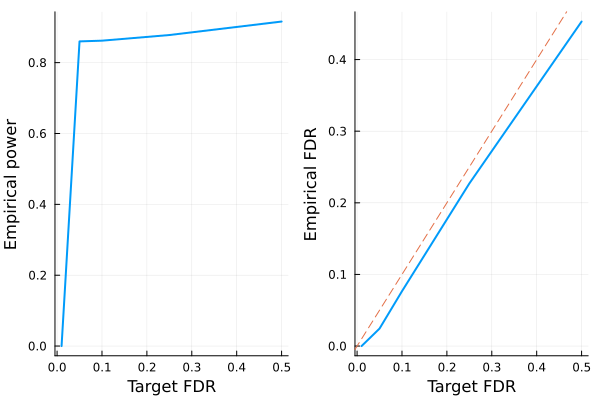

In [40]:
# run 10 simulations and compute empirical power/FDR
nsims = 10
empirical_power = zeros(5)
empirical_fdr = zeros(5)
for i in 1:nsims
    @time knockoff_filter = fit_lasso(y, X, method=:mvr)
    FDR = knockoff_filter.fdr_target
    for i in eachindex(FDR)
        selected = knockoff_filter.selected[i]
        power = length(selected ∩ correct_position) / k
        fdp = length(setdiff(selected, correct_position)) / max(length(selected), 1)
        empirical_power[i] += power
        empirical_fdr[i] += fdp
    end
end
empirical_power ./= nsims
empirical_fdr ./= nsims

# visualize FDR and power
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

**Conclusion:** 

+ LASSO + knockoffs controls the false discovery rate at below the target (dashed line). Thus, one trade power for FDR control. 
+ The power of standard LASSO is better, but it comes with high empirical FDR that one cannot control via cross validation. 
+ If one does not have the true mean and covariance of the $p$ dimensional covariates, Knockoffs.jl will estimate them with sample mean and a shrunken (default = ledoit wolf) estimator. 
+ Multiple simultaneous knockoffs increases power at the expensive of larger regression problem. 
+ Approximate constructions can be leveraged for extremely large problems, e.g. $p > 10000$. 